In [5]:
% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import numpy as np
import lightkurve as lk
import threemultis
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting

In [7]:
tpfs = lk.search_targetpixelfile('K2-198').download_all()

Sampling 4 chains: 100%|██████████| 208/208 [00:14<00:00,  7.16draws/s]
Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logrho, logsigma, logs2]
Sampling 4 chains: 100%|██████████| 400/400 [00:15<00:00, 25.74draws/s]
The acceptance probability does not match the target. It is 0.8367953700311033, but should be close to 0.9. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8305599785618025, but should be close to 0.9. Try to increase the number of tuning steps.
100%|██████████| 50/50 [03:02<00:00,  3.64s/it]


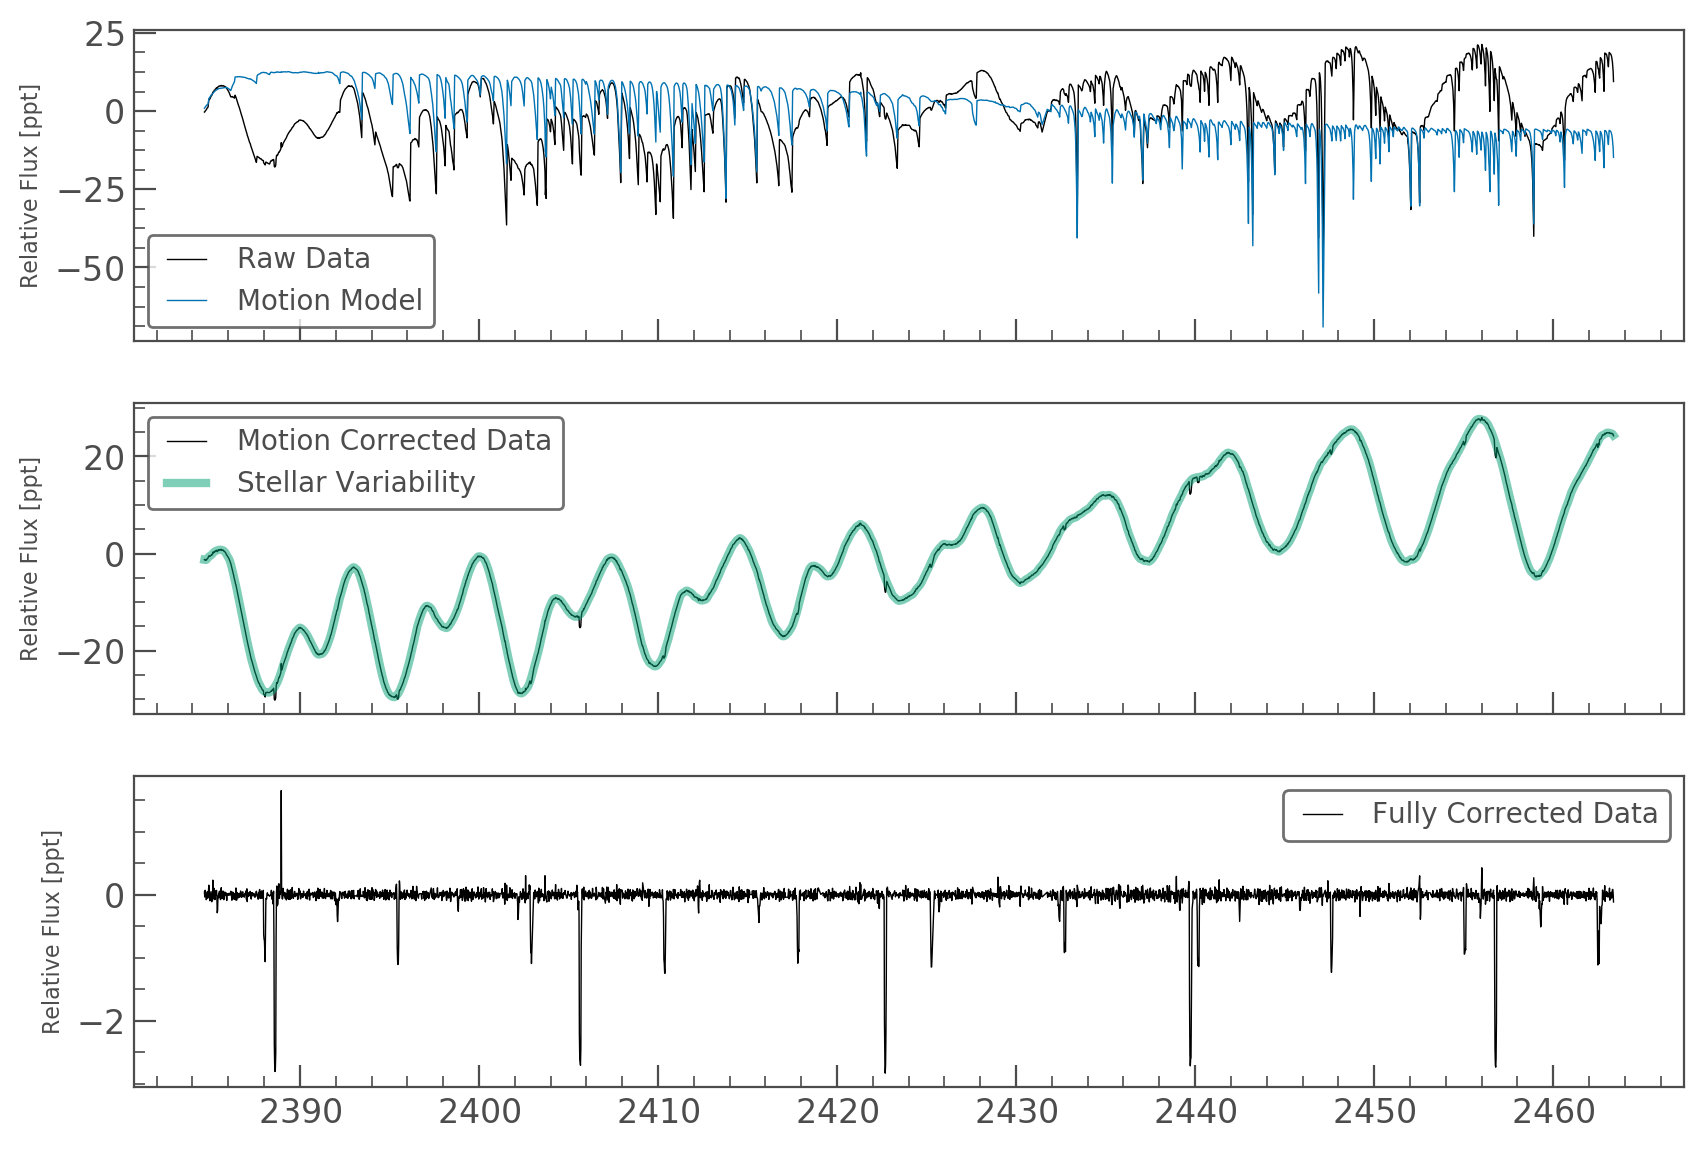

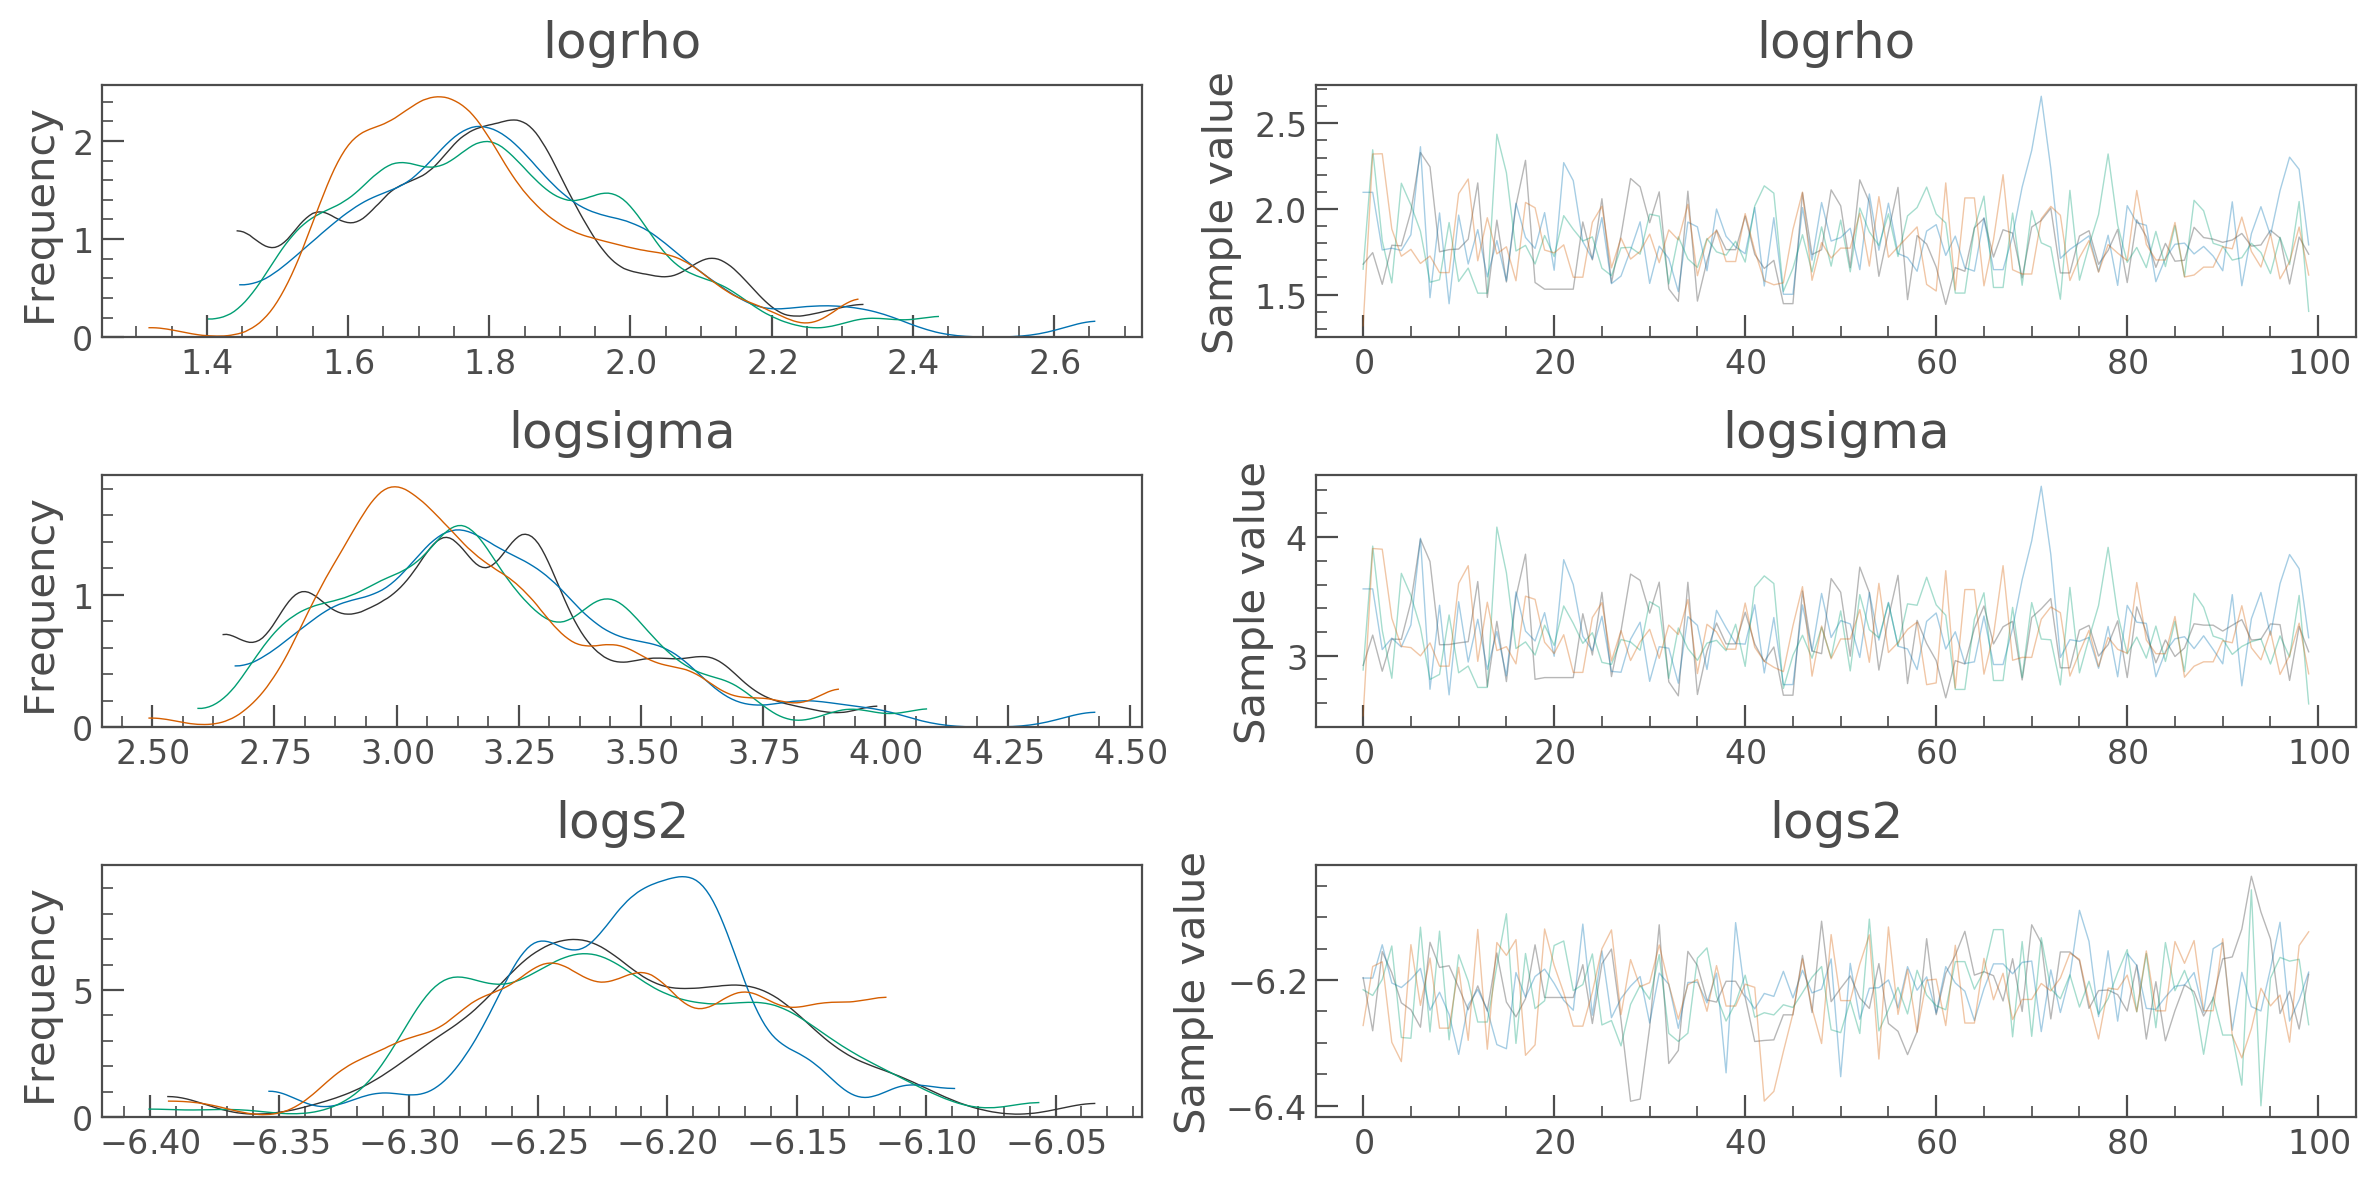

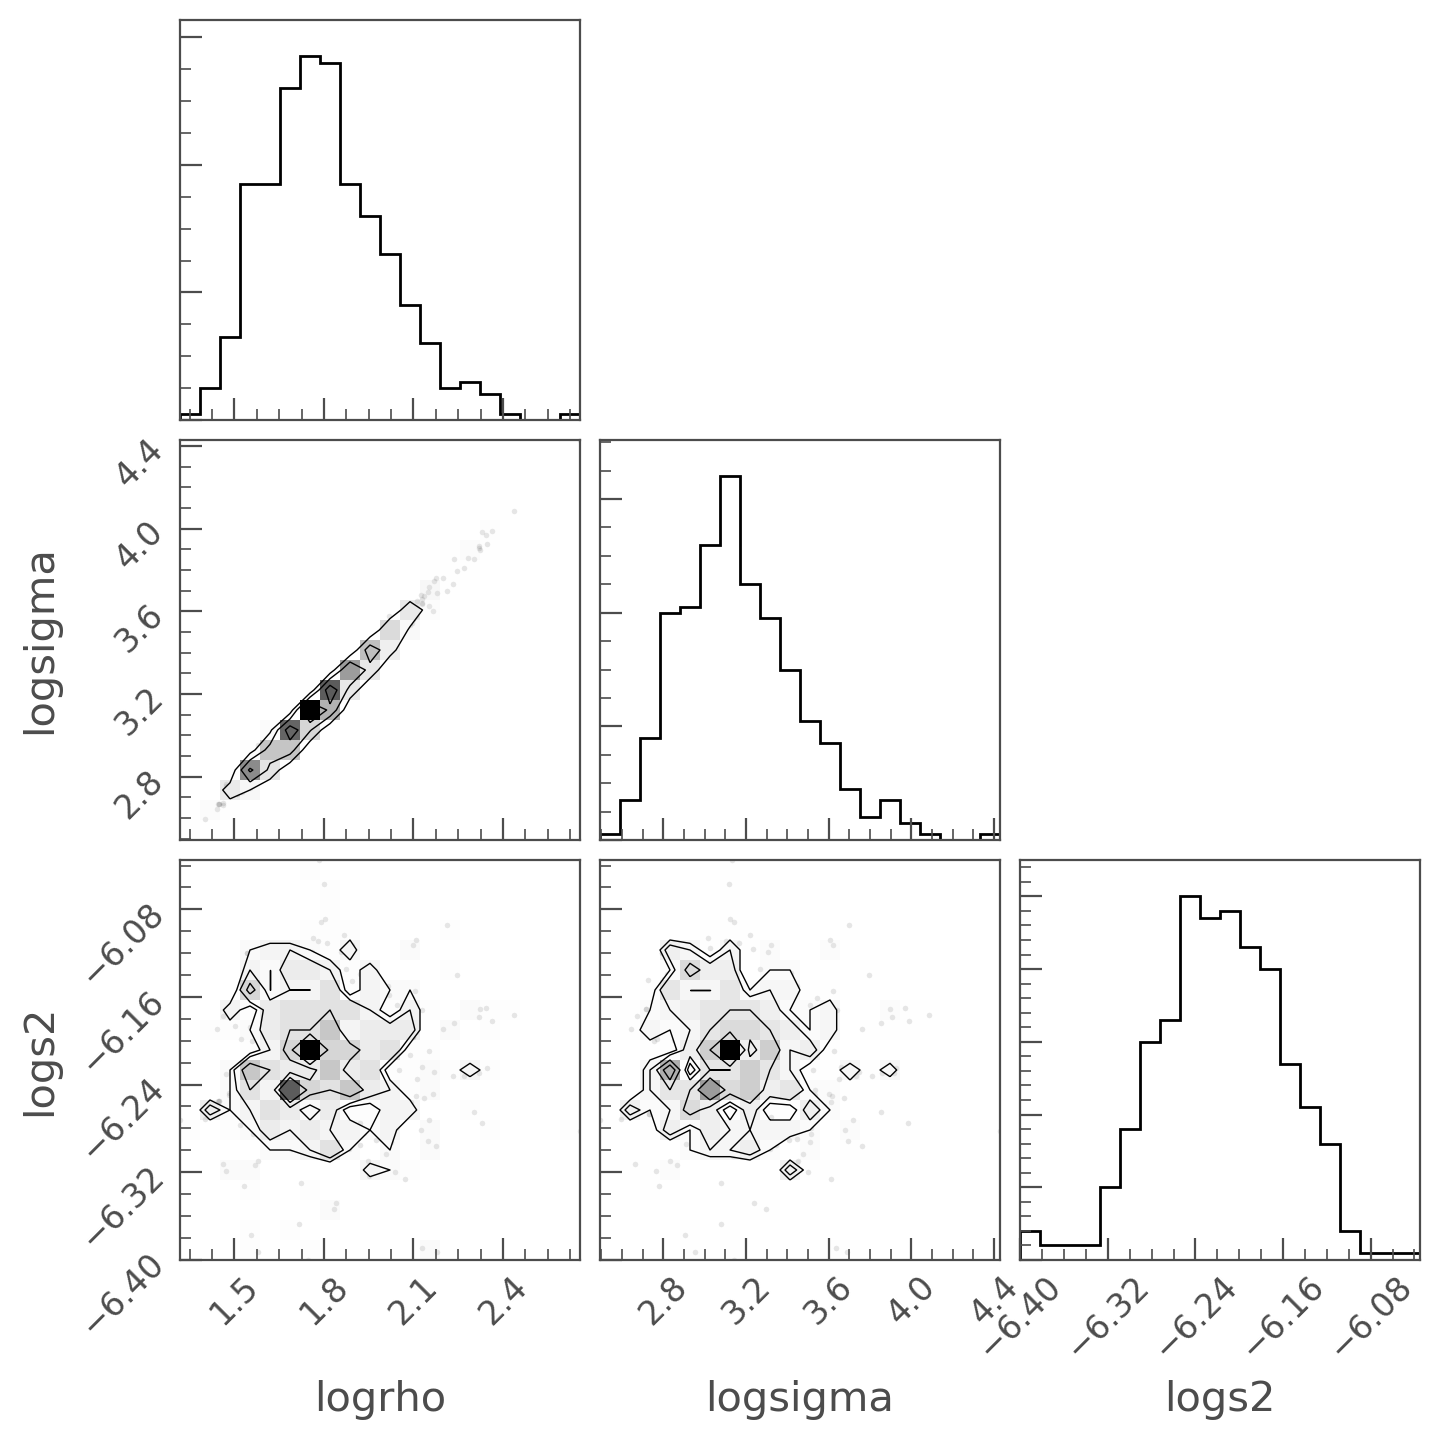

In [8]:
clcs = []     # Corrected Light Curves
for tpf in tpfs:
    tpf = tpf[10:]
    tpf = tpf[np.in1d(tpf.time, tpf.to_lightcurve(aperture_mask='all').remove_nans().time)]
    tpf = tpf[tpf.to_lightcurve().normalize().flux > 0.8]
    
    
    mask = threemultis.utils.planet_mask(tpf.time, 'K2-198')
    clc = threemultis.fit.PLD(tpf, planet_mask=mask, trim=2, ndraws=100)
    clcs.append(clc)
    break

In [ ]:
clc = clcs[0].append(clcs[1])

In [ ]:
clc.plot();

In [ ]:
params = threemultis.utils.get_params('K2-198')
threemultis.utils.planet_plot(clc, 'K2-198', nbin=5);

In [ ]:
trace, mask = threemultis.fit.fit_planets(clc, period_value=list(params['Period']),
                                            t0_value=list(params['T0']), depth_value=list(params['Depth']),
                                            R_star=(params.loc[0, 'R_star'], params.loc[0, 'R_star_error']),
                                            M_star=(params.loc[0, 'M_star'], params.loc[0, 'M_star_error']),
                                            T_star=(params.loc[0, 'T_star'], params.loc[0, 'T_star_error']), ndraws=2000)

In [ ]:
import pymc3 as pm
import corner
import astropy.units as u
varnames = varnames=["r_pl", "b", "t0", "logP", "r_star", "m_star", "u_star", "mean"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)

# Convert the radius to Earth radii
samples["r_pl__0"] = (np.array(samples["r_pl__0"]) * u.R_sun).to(u.R_earth).value
samples["r_pl__1"] = (np.array(samples["r_pl__1"]) * u.R_sun).to(u.R_earth).value


corner.corner(samples);

In [ ]:
fig = threemultis.utils.plot_folded_transits(clc, trace, mask, 'K2-198');
fig.savefig('figures/K2-198.png', dpi=150, bbox_inches='tight')

In [ ]:
print(threemultis.utils.latex_trace(trace, 'K2-198'))